In [1]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from scipy.stats import spearmanr

plt.style.use("default")


## Part A — Data Preparation


In [3]:
#Reading the data
trades = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/ds_aiyan/csv_files/historical_data.csv"
)

sentiment = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/ds_aiyan/csv_files/fear_greed_index.csv"
)
print("Trades shape:", trades.shape)
print("Sentiment shape:", sentiment.shape)


Trades shape: (211224, 16)
Sentiment shape: (2644, 4)


In [4]:

# Missing values
print("Missing values (Trades):")
print(trades.isna().sum())

print("\nMissing values (Sentiment):")
print(sentiment.isna().sum())

# Duplicates
print("\nDuplicate rows in Trades:", trades.duplicated().sum())
print("Duplicate rows in Sentiment:", sentiment.duplicated().sum())


Missing values (Trades):
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

Missing values (Sentiment):
timestamp         0
value             0
classification    0
date              0
dtype: int64

Duplicate rows in Trades: 0
Duplicate rows in Sentiment: 0


In [7]:
# Convert timestamps properly (day-first format)
trades['date'] = pd.to_datetime(
    trades['Timestamp IST'],
    format="%d-%m-%Y %H:%M",   # because your format is 18-03-2025 12:50
    errors='coerce'
).dt.date

# Convert sentiment date (usually already clean ISO format)
sentiment['date'] = pd.to_datetime(
    sentiment['date'],
    errors='coerce'
).dt.date

# Optional: check for conversion failures
print("Null dates in trades:", trades['date'].isna().sum())
print("Null dates in sentiment:", sentiment['date'].isna().sum())

# Merge daily
merged = trades.merge(sentiment, on='date', how='inner')

print("Merged shape:", merged.shape)
merged.head()

Null dates in trades: 0
Null dates in sentiment: 0
Merged shape: (211218, 20)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,date,timestamp,value,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02,1733117400,80,Extreme Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02,1733117400,80,Extreme Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02,1733117400,80,Extreme Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02,1733117400,80,Extreme Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02,1733117400,80,Extreme Greed


### Key Metrics Creation



In [11]:
# ============================================================
# Key Metrics Construction
# ============================================================

# ------------------------------------------------------------
# 1. Daily PnL per Trader
# ------------------------------------------------------------
# Aggregate total Closed PnL for each trader on each date

daily_pnl = (
    merged
    .groupby(['date', 'Account'])['Closed PnL']
    .sum()
    .reset_index(name='daily_pnl')
)


# ------------------------------------------------------------
# 2. Win Rate per Trader
# ------------------------------------------------------------
# A trade is considered a win if Closed PnL > 0

merged['win'] = merged['Closed PnL'] > 0

win_rate = (
    merged
    .groupby('Account')['win']
    .mean()
    .reset_index(name='win_rate')
)


# ------------------------------------------------------------
# 3. Number of Trades per Day
# ------------------------------------------------------------
# Count total trades executed each day

trades_per_day = (
    merged
    .groupby('date')
    .size()
    .reset_index(name='num_trades')
)


# ------------------------------------------------------------
# 4. Long / Short Ratio per Day
# ------------------------------------------------------------
# Count BUY and SELL trades per day and compute ratio

long_short = (
    merged
    .groupby(['date', 'Side'])
    .size()
    .unstack(fill_value=0)
)

# Ensure both BUY and SELL columns exist
if 'BUY' not in long_short.columns:
    long_short['BUY'] = 0

if 'SELL' not in long_short.columns:
    long_short['SELL'] = 0

# Compute long/short ratio
long_short['long_short_ratio'] = (
    long_short['BUY'] /
    long_short['SELL'].replace(0, 1)
)

long_short = long_short.reset_index()


# ------------------------------------------------------------
# Preview Output
# ------------------------------------------------------------
daily_pnl.head()

,date,Account,daily_pnl
0,2023-05-01,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,0.000000
1,2023-12-05,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,0.000000
2,2023-12-14,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,-205.434737
3,2023-12-15,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,-24.632034
4,2023-12-16,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,0.000000


In [31]:
# Average Trade Size Calculation
# ============================================================

# Overall average trade size (USD)
average_trade_size_overall = merged['Size USD'].mean()
print("Overall Average Trade Size (USD):", average_trade_size_overall)


# Average trade size per trader
average_trade_size_per_trader = (
    merged
    .groupby('Account')['Size USD']
    .mean()
    .reset_index(name='avg_trade_size')
)

print(average_trade_size_per_trader.head())


# Average trade size per day
average_trade_size_per_day = (
    merged
    .groupby('date')['Size USD']
    .mean()
    .reset_index(name='avg_trade_size_daily')
)

print(average_trade_size_per_day.head())

Overall Average Trade Size (USD): 5639.191610563493
                                      Account  avg_trade_size
0  0x083384f897ee0f19899168e3b1bec365f52a9012    16159.576734
1  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd     1653.226327
2  0x271b280974205ca63b716753467d5a371de622ab     8893.000898
3  0x28736f43f1e871e6aa8b1148d38d4994275d72c4      507.626933
4  0x2c229d22b100a7beb69122eed721cee9b24011dd     3138.894782
         date  avg_trade_size_daily
0  2023-05-01            159.000000
1  2023-12-05           5556.203333
2  2023-12-14          10291.213636
3  2023-12-15           5304.975000
4  2023-12-16           5116.256667


In [34]:
#Leverage Proxy Distribution (Using Position Size as Risk Proxy)
quantiles = merged['Size USD'].quantile([0.33, 0.66])

def exposure_bucket(size):
    if size <= quantiles[0.33]:
        return 'Low Exposure'
    elif size <= quantiles[0.66]:
        return 'Medium Exposure'
    else:
        return 'High Exposure'

merged['exposure_bucket'] = merged['Size USD'].apply(exposure_bucket)

exposure_distribution = merged['exposure_bucket'].value_counts()

print("Exposure Bucket Distribution:")
print(exposure_distribution)



Exposure Bucket Distribution:
exposure_bucket
High Exposure      71814
Low Exposure       69708
Medium Exposure    69696
Name: count, dtype: int64


## Part B — Sentiment Analysis


In [13]:
# Create sentiment categories using numeric index (0–100 scale)

merged['sentiment_category'] = pd.cut(
    merged['value'],          # numeric Fear & Greed index column
    bins=[0, 40, 60, 100],
    labels=['Fear', 'Neutral', 'Greed']
)


# Compute average Closed PnL per sentiment category

sentiment_pnl = (
    merged
    .groupby('sentiment_category')['Closed PnL']
    .mean()
)

print(sentiment_pnl)



sentiment_category
Fear       41.500637
Neutral    49.737662
Greed      54.038403
Name: Closed PnL, dtype: float64


/tmp/ipython-input-2619096168.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('sentiment_category')['Closed PnL']


# Visualization

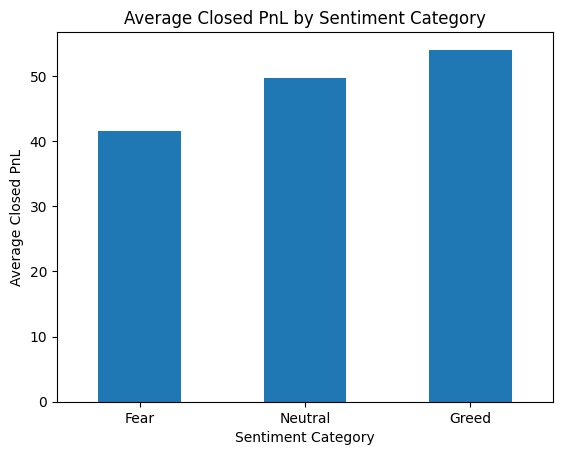

In [14]:
plt.figure()
sentiment_pnl.plot(kind='bar')
plt.title("Average Closed PnL by Sentiment Category")
plt.ylabel("Average Closed PnL")
plt.xlabel("Sentiment Category")
plt.xticks(rotation=0)
plt.show()

### Trader Segmentation


In [17]:
# ============================================================
# Trader Segmentation Based on Position Size (Risk Proxy)
# ============================================================

median_size = merged['Size USD'].median()

merged['risk_segment'] = np.where(
    merged['Size USD'] > median_size,
    'High Exposure',
    'Low Exposure'
)

seg_perf = (
    merged
    .groupby('risk_segment')['Closed PnL']
    .mean()
)

print(seg_perf)

risk_segment
High Exposure    92.719310
Low Exposure      4.380971
Name: Closed PnL, dtype: float64


/tmp/ipython-input-2376882571.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('sentiment_category')['win']


sentiment_category
Fear       0.406973
Neutral    0.398622
Greed      0.424186
Name: win, dtype: float64


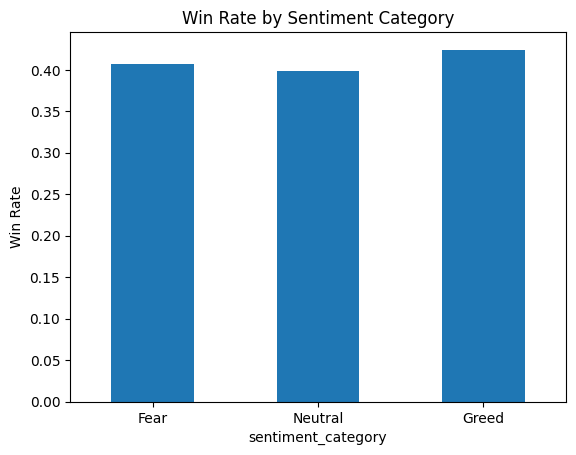

In [18]:

# Win Rate by Sentiment


win_rate_by_sentiment = (
    merged
    .groupby('sentiment_category')['win']
    .mean()
)

print(win_rate_by_sentiment)

plt.figure()
win_rate_by_sentiment.plot(kind='bar')
plt.title("Win Rate by Sentiment Category")
plt.ylabel("Win Rate")
plt.xticks(rotation=0)
plt.show()

/tmp/ipython-input-2956813919.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('sentiment_category')['Closed PnL']


sentiment_category
Fear        793.533050
Neutral     928.911143
Greed      1009.882405
Name: Closed PnL, dtype: float64


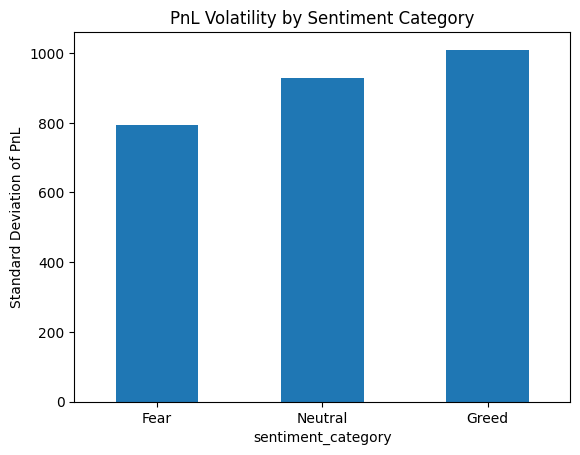

In [19]:
# ------------------------------------------------------------
# PnL Volatility by Sentiment (Risk Proxy)
# ------------------------------------------------------------

volatility_by_sentiment = (
    merged
    .groupby('sentiment_category')['Closed PnL']
    .std()
)

print(volatility_by_sentiment)

plt.figure()
volatility_by_sentiment.plot(kind='bar')
plt.title("PnL Volatility by Sentiment Category")
plt.ylabel("Standard Deviation of PnL")
plt.xticks(rotation=0)
plt.show()

/tmp/ipython-input-3803785291.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('sentiment_category')


sentiment_category
Fear       72565
Neutral    58035
Greed      80618
dtype: int64


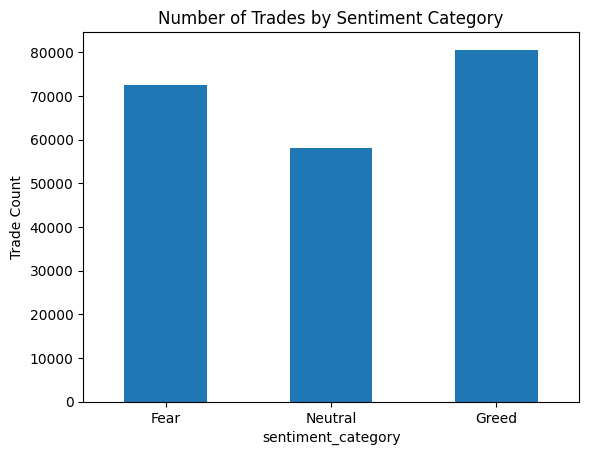

In [20]:
# Trade Frequency by Sentiment
# ------------------------------------------------------------

trades_by_sentiment = (
    merged
    .groupby('sentiment_category')
    .size()
)

print(trades_by_sentiment)

plt.figure()
trades_by_sentiment.plot(kind='bar')
plt.title("Number of Trades by Sentiment Category")
plt.ylabel("Trade Count")
plt.xticks(rotation=0)
plt.show()

/tmp/ipython-input-1586068240.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('sentiment_category')['Size USD']


sentiment_category
Fear       6921.120365
Neutral    6391.522645
Greed      3943.730403
Name: Size USD, dtype: float64


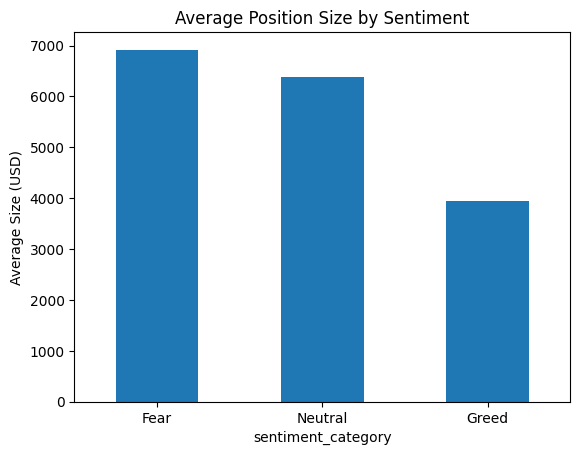

In [21]:
# Position Size by Sentiment
# ------------------------------------------------------------

size_by_sentiment = (
    merged
    .groupby('sentiment_category')['Size USD']
    .mean()
)

print(size_by_sentiment)

plt.figure()
size_by_sentiment.plot(kind='bar')
plt.title("Average Position Size by Sentiment")
plt.ylabel("Average Size (USD)")
plt.xticks(rotation=0)
plt.show()

In [22]:
# Long / Short Bias by Sentiment
# ------------------------------------------------------------

side_distribution = (
    merged
    .groupby(['sentiment_category', 'Side'])
    .size()
    .unstack(fill_value=0)
)

print(side_distribution)

Side                  BUY   SELL
sentiment_category              
Fear                35992  36573
Neutral             29115  28920
Greed               37583  43035


/tmp/ipython-input-264354815.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['sentiment_category', 'Side'])


In [27]:
# ------------------------------------------------------------
# Trader Segmentation by Trading Frequency
# ------------------------------------------------------------

trades_per_trader = merged.groupby('Account').size()
median_trades = trades_per_trader.median()

frequency_segment = np.where(
    trades_per_trader > median_trades,
    'Frequent Trader',
    'Infrequent Trader'
)

frequency_df = pd.DataFrame({
    'Account': trades_per_trader.index,
    'frequency_segment': frequency_segment
})

merged = merged.merge(frequency_df, on='Account')

frequency_performance = (
    merged
    .groupby('frequency_segment')['Closed PnL']
    .mean()
)

print(frequency_performance)

frequency_segment
Frequent Trader      42.493421
Infrequent Trader    95.216371
Name: Closed PnL, dtype: float64


In [29]:
# ------------------------------------------------------------
# Trader Segmentation by Consistency (PnL Volatility)
# ------------------------------------------------------------

pnl_std = merged.groupby('Account')['Closed PnL'].std()
median_std = pnl_std.median()

consistency_segment = np.where(
    pnl_std < median_std,
    'Consistent Trader',
    'Inconsistent Trader'
)

consistency_df = pd.DataFrame({
    'Account': pnl_std.index,
    'consistency_segment': consistency_segment
})

merged = merged.merge(consistency_df, on='Account')

consistency_performance = (
    merged
    .groupby('consistency_segment')['Closed PnL']
    .mean()
)

print(consistency_performance)

consistency_segment
Consistent Trader      16.697081
Inconsistent Trader    99.809238
Name: Closed PnL, dtype: float64


# BONUS


In [39]:
# Prepare Daily Trader Dataset for Prediction


# Aggregate daily features per trader
daily_features = (
    merged
    .groupby(['date', 'Account'])
    .agg({
        'Closed PnL': 'sum',
        'Size USD': 'mean',
        'win': 'mean',
        'value': 'mean'   # sentiment index
    })
    .reset_index()
)

# Sort for shifting
daily_features = daily_features.sort_values(['Account', 'date'])

# Create next-day PnL target
daily_features['next_day_pnl'] = (
    daily_features
    .groupby('Account')['Closed PnL']
    .shift(-1)
)

# Create profitability bucket (classification target)
daily_features['target'] = np.where(
    daily_features['next_day_pnl'] > 0,
    1,
    0
)

# Drop last rows with NaN target
daily_features = daily_features.dropna()

daily_features.head()

,date,Account,Closed PnL,Size USD,win,value,next_day_pnl,target
511,2024-11-11,0x083384f897ee0f19899168e3b1bec365f52a9012,0.0,5089.718249,0.000000,76.0,0.0,0
534,2024-11-17,0x083384f897ee0f19899168e3b1bec365f52a9012,0.0,7976.664412,0.000000,90.0,0.0,0
538,2024-11-18,0x083384f897ee0f19899168e3b1bec365f52a9012,0.0,23734.500000,0.000000,83.0,-21227.0,0
560,2024-11-22,0x083384f897ee0f19899168e3b1bec365f52a9012,-21227.0,28186.666667,0.000000,94.0,1603.1,1
575,2024-11-26,0x083384f897ee0f19899168e3b1bec365f52a9012,1603.1,17248.148148,0.444444,79.0,-132271.0,0


In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Feature matrix
X = daily_features[['Size USD', 'win', 'value']]
y = daily_features['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6233766233766234
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       174
           1       0.62      1.00      0.77       288

    accuracy                           0.62       462
   macro avg       0.31      0.50      0.38       462
weighted avg       0.39      0.62      0.48       462



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Aggregate trader-level features
trader_features = (
    merged
    .groupby('Account')
    .agg({
        'Closed PnL': 'mean',
        'Size USD': 'mean',
        'win': 'mean'
    })
)

# Add trade frequency
trader_features['trade_count'] = merged.groupby('Account').size()

trader_features = trader_features.dropna()

trader_features.head()

,Closed PnL,Size USD,win,trade_count
Account,,,,
0x083384f897ee0f19899168e3b1bec365f52a9012,419.127768,16159.576734,0.359612,3818
0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,6.577654,1653.226327,0.442720,7280
0x271b280974205ca63b716753467d5a371de622ab,-18.492043,8893.000898,0.301917,3809
0x28736f43f1e871e6aa8b1148d38d4994275d72c4,9.951530,507.626933,0.438585,13311
0x2c229d22b100a7beb69122eed721cee9b24011dd,52.071011,3138.894782,0.519914,3239


In [43]:
# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(trader_features)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
trader_features['cluster'] = kmeans.fit_predict(scaled_features)

trader_features.head()

,Closed PnL,Size USD,win,trade_count,cluster
Account,,,,,
0x083384f897ee0f19899168e3b1bec365f52a9012,419.127768,16159.576734,0.359612,3818,0
0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,6.577654,1653.226327,0.442720,7280,2
0x271b280974205ca63b716753467d5a371de622ab,-18.492043,8893.000898,0.301917,3809,2
0x28736f43f1e871e6aa8b1148d38d4994275d72c4,9.951530,507.626933,0.438585,13311,1
0x2c229d22b100a7beb69122eed721cee9b24011dd,52.071011,3138.894782,0.519914,3239,2


In [44]:
cluster_summary = trader_features.groupby('cluster').mean()
print(cluster_summary)

         Closed PnL      Size USD       win   trade_count
cluster                                                  
0        203.649635  10353.397560  0.439536   4009.000000
1         38.390661   1915.636756  0.379881  20003.833333
2         30.227394   4033.276520  0.381526   3077.642857


In [50]:
%%writefile app.py
import streamlit as st
import pandas as pd

st.title("Trader Behavior vs Market Sentiment Dashboard")

# -----------------------------
# Load datasets
# -----------------------------
trades = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ds_aiyan/csv_files/historical_data.csv")
sentiment = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ds_aiyan/csv_files/fear_greed_index.csv")

# -----------------------------
# Convert timestamps to date
# -----------------------------
trades['date'] = pd.to_datetime(
    trades['Timestamp IST'],
    format="%d-%m-%Y %H:%M"
).dt.date

sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

# -----------------------------
# Merge datasets
# -----------------------------
df = trades.merge(sentiment, on='date', how='inner')

st.write("Merged Dataset Overview")
st.write(df.head())

# -----------------------------
# Metrics
# -----------------------------
st.metric("Total Trades", len(df))

# -----------------------------
# Sentiment Filter
# -----------------------------
sentiment_option = st.selectbox(
    "Select Sentiment Category",
    df['classification'].unique()
)

filtered = df[df['classification'] == sentiment_option]

st.write("Filtered Data")
st.write(filtered.head())

st.write("Average Closed PnL:", filtered['Closed PnL'].mean())

Writing app.py


In [61]:
from google.colab import files
files.download("app.py")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>